# Use Natural Language Processing to provide solutions to customer support problems.

## Introduction

The goal of this report is to explore customer support tickets data, analyze the text using Natural Language Processing (NLP) and propose solutions to customer issues based on existing information and trained unsupervised model.

The business problem we try to solve is to provide immediate answers to issues raised by the customer while saving company resources. The system can be consumed by support, sales operations and even internal engineering teams. The data sets to be used, contain large volume of available information of how to solve wide array of product and system related issues. We want to provide more fluent and natural way of accessing this information and obtaining the resolution without the need to manually dig the data or relay on specific person's domain knowledge.
<ol>
    <li>Consume the spread sheet and clean up the data using pandas.</li>
    <li>Explore data and visualize the data for common support issues.</li>
    <li>Train the NLP Model with the dataset using genism and nltk.</li>
    <li>Use the provided UI to state your problem and the resulting information will relate to the top found results using similar     sentence matching algorithm.</li>
</ol>

To find similar sentence we will be using embedding technique provided by <code>genism</code> called <code>**Doc2Vec**</code>. 
We could be using the ***bag-of-words*** model, but this research concentrates of using different approach such as ***word embedding***. The bag-of-words model transforms each document to a fixed-length vector of integers. Each vector has elements, where each element counts the number of times a particular word occurred in the document. The order of elements is arbitrary. Bag-of-words models are surprisingly effective but has ***2 major downsides***. First, we lose the words order and even if we try to sole it using n-grams we still experience ***data sparsity and high dimensionality***. Second, the model does not attempt to learn ***the meaning of the underlying words***, and as a consequence, the distance between vectors doesn’t always reflect the difference in meaning. 
As a result, we will be using <code>**Word2Vec**</code> model which ***embeds words in a lower-dimension vector space using shallow neural network***. As a result, set of word-vectors where vectors close together in vector space have similar meanings based on context, and word-vectors distant to each other have differing meanings. The algorithm used by <code>Word2Vec</code> act as if a document has another floating word-like vector, which contributes to all training predictions, and is updated like other word-vectors, but we will call it a doc-vector. There are 2 implementations.
<ul>
<li>Paragraph Vector - Distributed Memory (PV-DM)</li>
<li>Paragraph Vector - Distributed Bag of Words (PV-DBOW) </li>
</ul>
In our case we will be using PV-DM.
Find out more on <a href="https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html">genism documentation</a>


Before we train our model we will need to clean up the data and then explore some facts about the information we can extract that may help us understand where the pain points of the support tickets are.


### Istall the required packages

In [7]:
!pip install gensim
!pip install nltk
!pip install wordcloud

## Exploration
### Do some analytics on the available support text. Find out the common issues.

Explore the content of the issues section. To do this, first we will vectorize the text. Out of the vectors we can deduct the how many times diffeent words occur in total 

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import adjusted_rand_score
import numpy

In [38]:
#https://github.com/stotlyakov/datascience/blob/main/data/Live%20Site%20Issues.csv
path = '../data/Live Site Issues.csv'
liveSiteAll = pd.read_csv(path)

#Drop the columns that are not relevent to our needs
liveSiteAll.drop(['App Created By','App Modified By','Content Type','Modified','Modified By','Item Type','Item Type','Defect number','Assigned To','Status','Time Taken CE to Resolve the Issue','Folder Child Count','Path','Item Child Count','Time taken to unblock the customer'], inplace=True, axis=1)

#Work with the Issue column
liveSiteAllDescSol = liveSiteAll['Issue']

liveSiteAllDescSolSubset = liveSiteAllDescSol.head(20)
data = liveSiteAllDescSolSubset.values.tolist()
print(data)


['Microsoft Office 365 (CA) tenants being deleted because of missing MaintenanceSKU', 'Customer 0123456789 requires manual intervention', 'Customer 0123456789 Service Request requires manual intervention', 'Customer 0123456789 tenant is not created for Sage 100 ERP ', 'Sage Business Center consent issue', 'Office 365 Account that has gone suspended -  INC0732959 ', 'UK Account transfer failed for 122121, 12112 and 12121', '121221 - Invalid email, Requires Manual Intervention', 'Invalid email address for O365 US', 'Duplicate payroll elements found in SLS data', 'Customer Office 365 tenant deleted during sync', 'Cloud Flare protection to CE SignOn endpoint suddenly prevented traffic to reach service', '63823004 - x Trade Services. Tenant needs to be reinstated', 'O365 US - Customer address failed MS validation', '020202020 - Customer address not validated  by MS', 'Customer entitlement missng contract effective dates', 'O365 200c order was placed against 50c', 'Error finding commerce acc

In [28]:
import re

texts = data
cleanedText = []
for t in texts:
    cleanedText.append(re.sub('\d', '', t))
    
# Vectorization of the texts

# Convert a collection of raw documents to a matrix of TF-IDF features. TF-IDF is a statistical measure 
# that evaluates how relevant a word is to a document in a collection of documents. 

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(cleanedText).todense()

# used words (axis in our multi-dimensional space)
words = vectorizer.get_feature_names()
print("words", words)


words ['account', 'activate', 'address', 'business', 'ca', 'calling', 'ce', 'center', 'cloud', 'commerce', 'consent', 'contract', 'create', 'created', 'customer', 'data', 'dates', 'deleted', 'duplicate', 'effective', 'elements', 'email', 'endpoint', 'entitlement', 'erp', 'error', 'exception', 'failed', 'finding', 'flare', 'gone', 'intervention', 'invalid', 'issue', 'loguseraccess', 'maintenancesku', 'manual', 'message', 'microsoft', 'missing', 'missng', 'ms', 'needs', 'office', 'order', 'payroll', 'placed', 'prevented', 'protection', 'reach', 'reinstated', 'request', 'requires', 'sage', 'service', 'services', 'signon', 'sls', 'suddenly', 'suspended', 'sync', 'tenant', 'tenantid', 'tenants', 'trade', 'traffic', 'transfer', 'uk', 'useraccesslogsvc', 'validated', 'validation']


In [29]:
vectorizer.vocabulary_

{'microsoft': 38,
 'office': 43,
 'ca': 4,
 'tenants': 63,
 'deleted': 17,
 'missing': 39,
 'maintenancesku': 35,
 'customer': 14,
 'requires': 52,
 'manual': 36,
 'intervention': 31,
 'service': 54,
 'request': 51,
 'tenant': 61,
 'created': 13,
 'sage': 53,
 'erp': 24,
 'business': 3,
 'center': 7,
 'consent': 10,
 'issue': 33,
 'account': 0,
 'gone': 30,
 'suspended': 59,
 'uk': 67,
 'transfer': 66,
 'failed': 27,
 'invalid': 32,
 'email': 21,
 'address': 2,
 'duplicate': 18,
 'payroll': 45,
 'elements': 20,
 'sls': 57,
 'data': 15,
 'sync': 60,
 'cloud': 8,
 'flare': 29,
 'protection': 48,
 'ce': 6,
 'signon': 56,
 'endpoint': 22,
 'suddenly': 58,
 'prevented': 47,
 'traffic': 65,
 'reach': 49,
 'trade': 64,
 'services': 55,
 'needs': 42,
 'reinstated': 50,
 'ms': 41,
 'validation': 70,
 'validated': 69,
 'entitlement': 23,
 'missng': 40,
 'contract': 11,
 'effective': 19,
 'dates': 16,
 'order': 44,
 'placed': 46,
 'error': 25,
 'finding': 28,
 'commerce': 9,
 'activate': 1,
 'log

In [37]:
import plotly.graph_objects as go

sort_texts = sorted(vectorizer.vocabulary_.items(), key=lambda x: x[1], reverse=True)[:20]

xplot = []
yplot = []
for i in sort_texts:
    xplot.append(i[1])
    yplot.append(i[0])

dict_of_fig = dict({
    "data": [{"type": "bar",
              "x": xplot,
              "y": yplot}],
    "layout": {"title": {"text": "Show 20 most common words in the support ticket issue column"}}
})

fig = go.Figure(dict_of_fig)
fig.show()


Another way to display words density and occurrence is by using wordclouds as seen bellow.

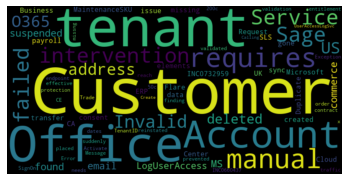

In [36]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

wordcl = WordCloud(width=800, height=400).generate(" ".join(data))
plt.imshow(wordcl, interpolation='bilinear')
plt.axis('off')
plt.show()

## Implementation

Now is the time to train the models and implement the sentence search ability.
We will be using two different approaches, ***Indexing by Latent Semantic Analysis*** and ***Doc2Vec*** with ***Paragraph Vector - Distributed Memory***. But, the result of the research will show that one algorithm is more superior then another. The main difference is that Word2vec is a prediction based model i.e given the vector of a word predict the context word vectors(skipgram) while, LSI is a count based model where similar terms have same counts for different documents.

### Doc2Vec with Paragraph Vector - Distributed Memory

In [4]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
#https://www.nltk.org/api/nltk.tokenize.html
#tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]
stop_words = stopwords.words('english')

#Remove some common elements that are nor valuable, we can add them to the stopword list
stop_words.extend(['-',':'])

#Create a function to clean up the words and select the ones that make sense in our case
def clenTokens(word_tokens):
    #filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            #Clean up all numbers and words with numbers but keep 365 because it has meaning to us, this increases the accuracy rate by 2-3%
            if re.match('^((?!365)\w*[0-9]\w*)$', w):
                continue
            else:
                filtered_sentence.append(w)
    return filtered_sentence



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stotlyakov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\stotlyakov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Make a TaggedDocument, a single document, made up of `words` (a list of unicode string tokens)
and `tags` (a list of tokens). Tags may be one or more unicode string
tokens, but typical practice (which will also be most memory-efficient) is
for the tags list to include a unique integer id as the only tag.
https://www.kite.com/python/docs/gensim.models.deprecated.doc2vec.TaggedDocument

In [63]:
from nltk.util import ngrams
tagged_data = [TaggedDocument(words=clenTokens(word_tokenize(_d.lower())), tags=[str(i)]) for i, _d in enumerate(data)]

In [64]:
tagged_data

[TaggedDocument(words=['microsoft', 'office', '365', '(', 'ca', ')', 'tenants', 'deleted', 'missing', 'maintenancesku'], tags=['0']),
 TaggedDocument(words=['customer', 'requires', 'manual', 'intervention'], tags=['1']),
 TaggedDocument(words=['customer', 'service', 'request', 'requires', 'manual', 'intervention'], tags=['2']),
 TaggedDocument(words=['customer', 'tenant', 'created', 'sage', 'erp'], tags=['3']),
 TaggedDocument(words=['sage', 'business', 'center', 'consent', 'issue'], tags=['4']),
 TaggedDocument(words=['office', '365', 'account', 'gone', 'suspended'], tags=['5']),
 TaggedDocument(words=['uk', 'account', 'transfer', 'failed', ','], tags=['6']),
 TaggedDocument(words=['invalid', 'email', ',', 'requires', 'manual', 'intervention'], tags=['7']),
 TaggedDocument(words=['invalid', 'email', 'address', 'us'], tags=['8']),
 TaggedDocument(words=['duplicate', 'payroll', 'elements', 'found', 'sls', 'data'], tags=['9']),
 TaggedDocument(words=['customer', 'office', '365', 'tenant'

It is time to train the model. The following documentation gives good explanation of the parameters passed.
https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#training-the-model

In [65]:
max_epochs = 500
vec_size =200
alpha = 0.03
minimum_alpha = 0.0025
reduce_alpha = 0.0002

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=minimum_alpha,
                #distributed memory (PV-DM)
                dm = 1, 
                #very critical, if min is 2 ormore the result is inacurate, since the data is not big enough
                min_count=1)
model.build_vocab(tagged_data)

# Train the model based on epochs parameter
for epoch in range(max_epochs):
    model.train(tagged_data, total_examples=model.corpus_count,epochs=20)
    
    
# Save model. 
model.save("similar_sentence.model")

Now we can create function that will use the model to find the best matching sentence 

In [69]:

def output_sentences(most_similar):
    print('\n')
    for label, index in [('Highest match', 0), ('Second match', 1), ('Third match', 2), ('Fourth match', 3)]:
      print(u'%s %s: %s\n' % (label, most_similar[index][1], data[int(most_similar[index][0])]))

def runDoc2VecModel(doc):
    model= Doc2Vec.load("similar_sentence.model")
    tokens = doc.split()
    vector = model.infer_vector(tokens)
    most_similar = model.dv.most_similar([vector]) 

    output_sentences(most_similar)

 ### Latent Semantic Indexing Analysis (LSI)
 
 For the second type of algorithm we are using Latent Semantic Indexing Analysis or  LSI. As the name suggests, it is the analysis of latent i.e. ***hidden semantics in a corpora of text***. A collection of documents can be represented as a ***huge term-document matrix***.The main goal of that algorithm is to transform the vectors from one space to another by using ***Singular Value Decomposition*** of term-document matrix. And the most importantly, it enables identifying patterns and relationships between terms and topics.
In addition, as the above mentioned approach, it considers cosine similarity to determine the similarity of two vectors. Cosine similarity is a standard measure in Vector Space Modeling


In [66]:
# remove common words and tokenize
from collections import defaultdict
from gensim import corpora
import re

stoplist = set('for a of the and to in - :'.split())

cleanedText = []
for t in data:
    cleanedText.append(re.sub('\d', '', t))

texts2 = [
    [word for word in document.lower().split() if word not in stoplist]
    for document in cleanedText
]

# remove words that appear only once
frequency = defaultdict(int)
for text in texts2:
    for token in text:
        frequency[token] += 1

texts2 = [
    [token for token in text if frequency[token] > 1]
    for text in texts2
]

dictionary = corpora.Dictionary(texts2)
corpus = [dictionary.doc2bow(text) for text in texts2]
from gensim import models
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=2)

def runLsiModel(doc):
    # doc2bow counts the number of occurrences of each distinct word, converts the 
    # word to its integer word id and returns the result as a sparse vector. 
    vec_bow = dictionary.doc2bow(doc.lower().split())
    vec_lsi = lsi[vec_bow]  # convert the query to LSI space
    #print(vec_lsi)
    from gensim import similarities
    index = similarities.MatrixSimilarity(lsi[corpus])  # transform corpus to LSI space and index it

    sims = index[vec_lsi]  # perform a similarity query against the corpus
    #print(list(enumerate(sims)))  # print (document_number, document_similarity) 2-tuples

    sims = sorted(enumerate(sims), key=lambda item: -item[1])
    for doc_position, doc_score in sims[:9]:
        print(doc_score, data[doc_position])

In [67]:
cleanedText

['Microsoft Office  (CA) tenants being deleted because of missing MaintenanceSKU',
 'Customer  requires manual intervention',
 'Customer  Service Request requires manual intervention',
 'Customer  tenant is not created for Sage  ERP ',
 'Sage Business Center consent issue',
 'Office  Account that has gone suspended -  INC ',
 'UK Account transfer failed for ,  and ',
 ' - Invalid email, Requires Manual Intervention',
 'Invalid email address for O US',
 'Duplicate payroll elements found in SLS data',
 'Customer Office  tenant deleted during sync',
 'Cloud Flare protection to CE SignOn endpoint suddenly prevented traffic to reach service',
 ' - x Trade Services. Tenant needs to be reinstated',
 'O US - Customer address failed MS validation',
 ' - Customer address not validated  by MS',
 'Customer entitlement missng contract effective dates',
 'O c order was placed against c',
 'Error finding commerce account:Commerce account not found',
 'Activate suspended tenant for Office Sage  US - I

In [68]:
for key, value in dictionary.items():
    print(key, ' : ', value)

0  :  deleted
1  :  office
2  :  customer
3  :  intervention
4  :  manual
5  :  requires
6  :  service
7  :  not
8  :  sage
9  :  tenant
10  :  account
11  :  inc
12  :  suspended
13  :  failed
14  :  invalid
15  :  address
16  :  o
17  :  us
18  :  found
19  :  ms
20  :  c
21  :  loguseraccess


Use the models and see which one performs better

In [75]:
# "my tennat got deleted"
# "address failed validation"
testText = "my tennat got deleted"
runLsiModel(testText)
runDoc2VecModel(testText)

0.999502 63823004 - x Trade Services. Tenant needs to be reinstated
0.99909574 UK Account transfer failed for 122121, 12112 and 12121
0.99577045 Duplicate payroll elements found in SLS data
0.99561965 Error finding commerce account:Commerce account not found
0.9952506 Sage Business Center consent issue
0.9893352 Activate suspended tenant for Office Sage 50 US - INC0660437 - 1321313131
0.98685205 Microsoft Office 365 (CA) tenants being deleted because of missing MaintenanceSKU
0.9587846 Office 365 Account that has gone suspended -  INC0732959 
0.9515136 Customer Office 365 tenant deleted during sync


Highest match 0.6758844256401062: Customer Office 365 tenant deleted during sync

Second match 0.6679433584213257: Microsoft Office 365 (CA) tenants being deleted because of missing MaintenanceSKU

Third match 0.5289478302001953: 63823004 - x Trade Services. Tenant needs to be reinstated

Fourth match 0.5114109516143799: O365 200c order was placed against 50c



### Conclusion
While we see that the confidence rate of the LSI model is higher there are a lot of false positives. We can see that the Doc2Vec algorithm captures the similarity in a batter way. External research also proves that the prediction based models are the better tool for similar sentence search (https://www.aclweb.org/anthology/Q15-1016/) . Neural network models have shown to perform quite better using these dense pretrained word2vec/doc2vec embedding for various tasks in NLP like sentence representation, information retrieval, knowledge extraction, semantic parsing and so on. 

### Further research
As we see from the neural approach doc2Vec or word2Vec, there is a difficulty when representing the accuracy. The algorithm provides a lot of fine-tuning mechanism that need to be explored. A lot of those options depend on the size of the data. Another improvement will be to add n-grams to the dictionary of tagged document. This will allow close match when only couple of words are entered in the search criteria.


## Resources
https://datascience.stackexchange.com/questions/68082/semantic-text-similarity-using-bert https://github.com/llSourcell/word_vectors_game_of_thrones-LIVE/blob/master/demo.ipynb https://github.com/llSourcell/word_vectors_game_of_thrones-LIVE/blob/master/Thrones2Vec.ipynb https://github.com/hanxiao/bert-as-service#building-a-qa-semantic-search-engine-in-3-minutes https://colab.research.google.com/drive/1W5yvUDjgidfiwIgo9ZMiztbaLyYOW2V5#scrollTo=beP_QyyXkhsl https://shangan.medium.com/semantic-similar-sentences-with-your-dataset-nlp-94fd1d49d231 https://rare-technologies.com/doc2vec-tutorial/ https://realpython.com/nltk-nlp-python/ https://towardsdatascience.com/overview-of-text-similarity-metrics-3397c4601f50 https://stackabuse.com/python-for-nlp-working-with-the-gensim-library-part-1
https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html
https://towardsdatascience.com/word2vec-for-phrases-learning-embeddings-for-more-than-one-word-727b6cf723cf
https://www.linkedin.com/pulse/word-embeddings-word2vec-latent-semantic-analysis-shrikar-archak
